In [225]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class MonotoneCubic(nn.Module):
    def __init__(self, init_method='random'):
        super().__init__()
        if init_method == 'random':
            self.a = nn.Parameter(0.5*torch.randn(1))
            self.b = nn.Parameter(torch.randn(1))
            self.c = nn.Parameter(0.5*torch.ones(1))
            self.d = nn.Parameter(0.5*torch.randn(1))
        elif init_method == 'identity':
            self.a = nn.Parameter(torch.zeros(1))
            self.b = nn.Parameter(torch.zeros(1))
            self.c = nn.Parameter(torch.ones(1))
            self.d = nn.Parameter(torch.zeros(1))

    def polynomial_coeffs(self):
        a, b, c, d = self.a, self.b, self.c, self.d
        a, c = a.abs(), c.abs()
        b = torch.tanh(b) * torch.sqrt(3 * a * c)
        return a, b, c, d

    def forward(self, x):
        a, b, c, d = self.polynomial_coeffs()
        y =  a * x**3 + b * x**2 + c * x + d
        return y

    def inverse(self, y):
        a, b, c, d = self.polynomial_coeffs()
        D0 = b**2 - 3*a*c 
        D1 = 2*b**3 - 9*a*b*c + 27*a**2*(d-y)
        C1 = (D1 +torch.sqrt(D1**2 - 4*D0**3)) / 2
        C2 = (D1 -torch.sqrt(D1**2 - 4*D0**3)) / 2
        C = torch.where(C1.abs() >0, C1, C2)
        C = C.sign() * C.abs()**(1/3)
        x = -1/ (3*a) *(b + C +D0/C) 
        return x

class InvSequential(nn.Sequential):
    def inverse(self, y):
        for module in reversed(self):
            y = module.inverse(y)
        return y

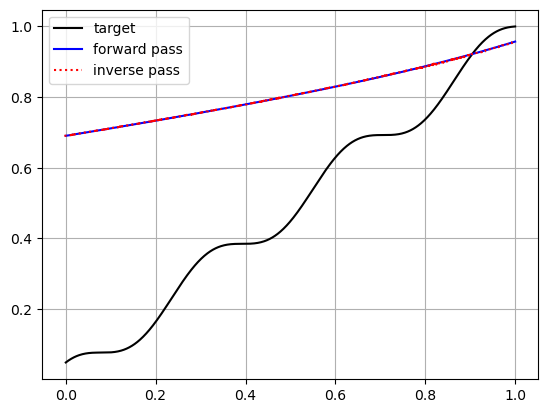

In [261]:
x = torch.linspace(0, 1, 1000)
target = torch.cos(20*x)+20*x
target = target/target.max()

model = InvSequential(*(MonotoneCubic("random") for _ in range(4)))
y = model(x).detach()
x_inv = model.inverse(y).detach()

plt.plot(x, target, "k", label='target')
plt.plot(x, y, "b", label='forward pass')
plt.plot(x_inv, y, ":r", label='inverse pass')
plt.legend()
plt.grid()
plt.show()

In [262]:
from tqdm.auto import tqdm
opt = torch.optim.Adam(model.parameters(), lr=0.0003)
losses = []
for i in (pbar:=tqdm(range(10000))):
    loss = ((model(x)- target)**2).mean()
    opt.zero_grad()
    loss.backward()
    opt.step()
    pbar.set_postfix({'loss': loss.item()})
    losses.append(loss.item())

  0%|          | 0/10000 [00:00<?, ?it/s]

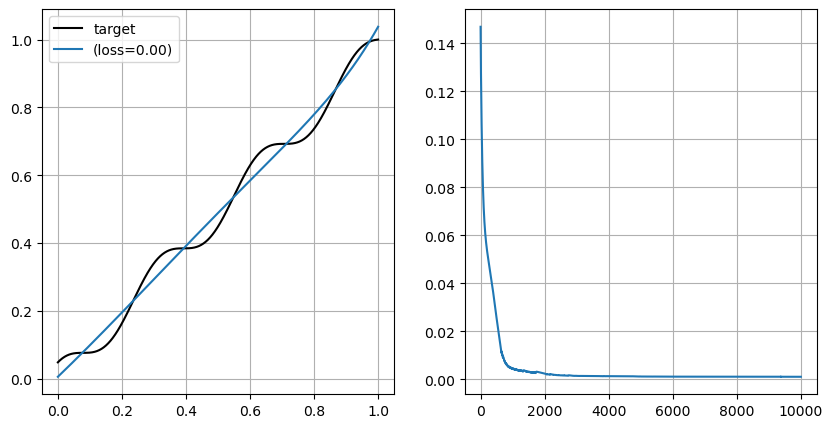

In [265]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(x, target, "k", label='target')
plt.plot(x, model(x).detach(), label=f'(loss={loss.item():.2f})')
plt.grid()
plt.legend()
plt.subplot(122)
plt.plot(losses)
plt.grid()
plt.show()